## Laplacian Eigenmaps

In [44]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline

## Dataset

The dataset is the citation network Cora.

It can be downloaded by clicking here

The following is the description of the dataset from the publisher,

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the subject attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer.

We assume that the dataset is stored in the directory

~/data/cora/

where the files cora.cites and cora.content can be located.

We are going to load the data into a networkx object.

In [45]:
data_location = os.path.expanduser("~/data/cora/")
g_nx = nx.read_edgelist(path=os.path.join(data_location,"cora.cites"))

In [46]:
y = pd.read_csv(os.path.join(data_location,"cora.content"), delimiter='\t', header=None)
y = y.iloc[:, [0, -1]]  # node id and label

In [47]:
len(g_nx.nodes())

2708

In [48]:
y.head(10)

,0,1434
0,31336,Neural_Networks
1,1061127,Rule_Learning
2,1106406,Reinforcement_Learning
3,13195,Reinforcement_Learning
4,37879,Probabilistic_Methods
5,1126012,Probabilistic_Methods
6,1107140,Theory
7,1102850,Neural_Networks
8,31349,Neural_Networks
9,1106418,Theory


In [49]:
colors = {'Case_Based': 'black',
          'Genetic_Algorithms': 'red',
          'Neural_Networks': 'blue',
          'Probabilistic_Methods': 'green',
          'Reinforcement_Learning': 'aqua',
          'Rule_Learning': 'purple',
          'Theory': 'yellow'}

### Calculate the graph Laplacian

In [50]:
A = nx.to_numpy_array(g_nx)
D = np.diag(A.sum(axis=1))  # sum rows

print(D)

[[168.   0.   0. ...   0.   0.   0.]
 [  0.   5.   0. ...   0.   0.   0.]
 [  0.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.   0.   0.]
 [  0.   0.   0. ...   0.   4.   0.]
 [  0.   0.   0. ...   0.   0.   2.]]


In [51]:
L = D-A  # The Graph Laplacian

### Calculate the eigenvectors and corresponding eigenv values

In [52]:
w, v = np.linalg.eigh(L)  # w is vector of eigenvalues
                          # v columns are eigenvectors

order = np.argsort(w)  # from smallest to largest eigenvalue
w = w[order]
v = v[:, order[1:32]]

In [53]:
print(w)

[-3.94602184e-15 -3.82390654e-15 -3.02090095e-15 ...  7.50272239e+01
  7.90471764e+01  1.69014150e+02]


In [54]:
print(v)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.67197982e-19  1.29258115e-28 -2.07651358e-17 ...  2.75359195e-31
   3.79020774e-19 -5.12916197e-18]
 [-2.17893625e-18  2.41061281e-28  1.68777356e-17 ...  2.13054331e-31
  -3.65460877e-19  1.50467980e-17]
 ...
 [-2.24668140e-18 -2.75985761e-31  4.76978731e-17 ...  3.50097953e-32
  -1.99492546e-19  9.77941784e-18]
 [-2.31875399e-18  4.31003862e-30  1.58952063e-17 ...  1.36018802e-32
   6.55200891e-19  1.01661824e-17]
 [ 1.84841162e-18 -1.65535605e-29  1.05650124e-16 ...  1.19200017e-31
   1.40589646e-19  1.18683379e-18]]


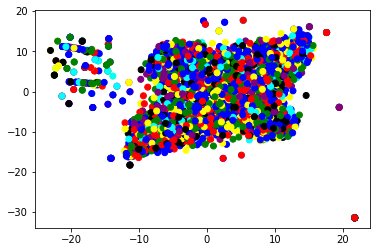

In [55]:
if True:
    tsne = TSNE(n_components=2)
    v_pr = tsne.fit_transform(v)
    plt.scatter(v_pr[:, 0], v_pr[:, 1], c=y[1434].map(colors))
    plt.show()

### Train a classifier

In [56]:
X = v
Y = y[1434].values

In [57]:
X.shape, Y.shape

((2708, 31), (2708,))

In [58]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=4)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

clf.fit(X_train, y_train)
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

print("score on X_train {}".format( f1_score(y_train, clf.predict(X_train), average='micro')))
print("score on X_test {}".format( f1_score(y_test, clf.predict(X_test), average='micro')))

print("Finished")

score on X_train 0.3187335092348285
score on X_test 0.28413284132841327
score on X_train 0.3187335092348285
score on X_test 0.28413284132841327
Finished


/Users/eli024/Projects/stellar-practical-ml-on-graphs/practical-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
